In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/vbd402/Documents/Projects/scoreoperator


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from src.data.synthetic_shapes import Circle
from src.utils.trainer import TrainerModule
from configs.circles_brownian import get_circles_brownian_config as get_config
from src.utils.plotting import plot_shape_with_pts, plot_trajectories

initial condition shape: (16, 2), target shape: (16, 2)


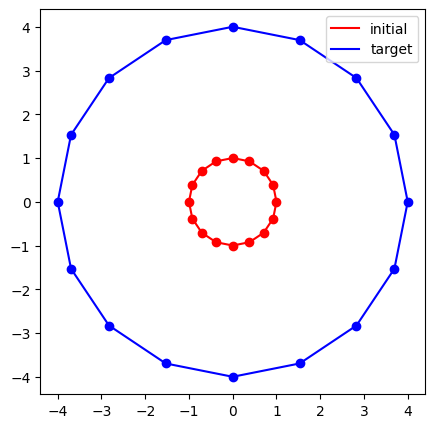

In [3]:
small_circle = Circle(r=1.0)
large_circle = Circle(r=4.0)

n_training_sample_pts = 16
small_circle_sample = small_circle.sample(n_training_sample_pts)
large_circle_sample = large_circle.sample(n_training_sample_pts)
print(f"initial condition shape: {small_circle_sample.shape}, target shape: {large_circle_sample.shape}")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plot_shape_with_pts(ax, small_circle_sample, color='r', label='initial')
ax = plot_shape_with_pts(ax, large_circle_sample, color='b', label='target')
ax.set_aspect('equal')
ax.legend()

In [7]:
config = get_config()
trainer = TrainerModule(
    config
)

In [8]:
trainer.train_model(
    pretrained=False,
    load_dir="/Users/vbd402/Documents/Projects/scoreoperator/pretrained/",
    prefix="circles"
)

Training:   1%|          | 1/100 [00:39<1:05:26, 39.66s/epoch, Epoch=0, eval_loss=1591.8494, train_loss=1601.7487]


KeyboardInterrupt: 

In [14]:
def true_brownian_score(t, x):
    return  - x / (t+1e-6)

def est_brownian_score(t, x):
    x_ = jnp.expand_dims(x, axis=0)
    t_ = jnp.expand_dims(t, axis=0)
    score = trainer.infer_model((x_, t_))
    return score.squeeze() 

In [15]:
true_score = true_brownian_score(0.7, small_circle_sample*1.2)
est_score = est_brownian_score(0.7, small_circle_sample*1.2)

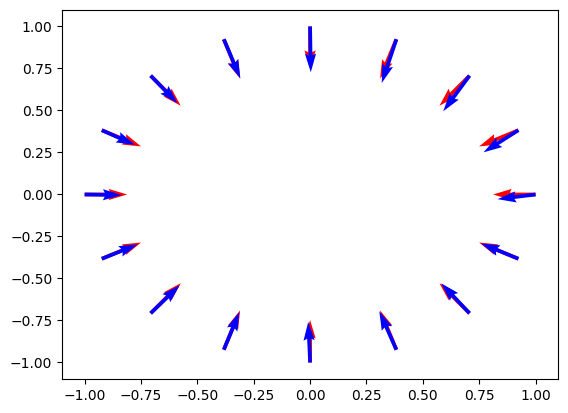

In [16]:
plt.quiver(small_circle_sample[:, 0], small_circle_sample[:, 1], true_score[:, 0], true_score[:, 1], color='r', label='true', scale=20)
plt.quiver(small_circle_sample[:, 0], small_circle_sample[:, 1], est_score[:, 0], est_score[:, 1], color='b', label='estimated', scale=20)

In [17]:
score_fn = lambda t, x: est_brownian_score(t, x.reshape(-1, 2)).flatten()
# score_fn = lambda t, x: true_brownian_score(t, x)

In [20]:
n_eval_sample_pts = 128
x0 = (large_circle.sample(n_eval_sample_pts) - small_circle.sample(n_eval_sample_pts)).flatten()
xs, _ = trainer.diffuser.solve_reverse_bridge_sde(rng_key=jax.random.PRNGKey(4), x0=x0, n_steps=500, score_fn=score_fn)
xs = xs.reshape(-1, n_eval_sample_pts, 2)

<Axes: xlabel='$x$', ylabel='$y$'>

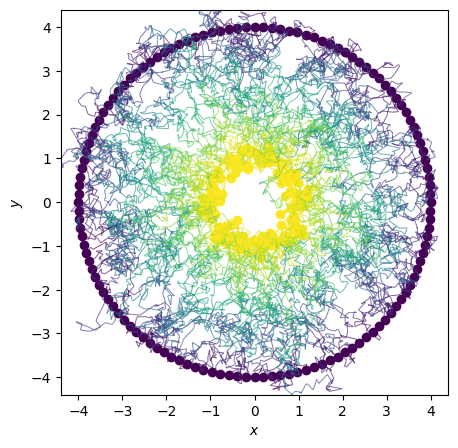

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_trajectories(ax, xs+small_circle.sample(n_eval_sample_pts), target=small_circle.sample(n_eval_sample_pts), plot_target=False)